# FPL Predictor Modeling III

### Package Installments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = "ticks")
%matplotlib inline
from scipy.interpolate import make_interp_spline

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### Useful functions

In [3]:
def best_degree(model, df_x,df_y):
    degree = np.arange(10)
    train_score, val_score = validation_curve(model, df_x, df_y, 'polynomialfeatures__degree', degree, cv = 5)
    degree = pd.Series(degree)
    train = pd.Series(np.median(train_score,1))
    val = pd.Series(np.median(val_score,1))
    record = pd.DataFrame({'degree': degree, 'train_score': train, 'val_score': val})
    record_max = record.loc[record[['val_score']].idxmax(), 'degree']
    record_max2 = record_max.reset_index(drop = True)
    return record_max2[0]

In [4]:
def val_curve(model, df_x, df_y):
    degree = np.arange(1,6)
    train_score, val_score = validation_curve(model, df_x, df_y, 'polynomialfeatures__degree', degree, cv = 5)
    best = best_degree(model,df_x,df_y)
    deg = np.linspace(1,5,200)
    smooth_train = make_interp_spline(degree, np.median(train_score,1))
    smooth_val = make_interp_spline(degree, np.median(val_score, 1))
    
    
    ##plt.plot(degree, np.median(train_score,1), color = 'blue', label = 'training curve')
    ##plt.plot(degree, np.median(val_score,1), color = 'red', label = 'validation curve')
    plt.plot(deg, smooth_train(deg), color = 'blue', label = 'training curve')
    plt.plot(deg, smooth_val(deg), color = 'red', label = 'validation curve')
    plt.scatter(best, np.max(np.median(val_score,1)), marker = 'x', color = 'black', label = 'max')
    plt.legend(loc = 'best')
    plt.xlabel('Degree')
    plt.ylabel('Accuracy score')
    plt.ylim(0,1);

In [5]:
def split_data(df_new, rand_state = 69):
    df_x = df_new[['player_name','goals_scored', 'assists','minutes', 'position_index', 'clean_sheets', 'total_points']]
    df_y = df_new['ict_index']
    df_xm = df_new[['goals_scored','assists','minutes', 'clean_sheets', 'position_index']]
    df_xtrain, df_xtest, df_ytrain, df_ytest = train_test_split(df_x, df_y, random_state = rand_state, train_size = 0.5)
    df_xtrain_new = df_xtrain[['goals_scored', 'assists','minutes', 'clean_sheets', 'position_index']]
    df_xtest_new = df_xtest[['goals_scored', 'assists','minutes','clean_sheets', 'position_index']]
    return (df_x, df_y, df_xm, df_xtrain, df_xtest, df_ytrain, df_ytest, df_xtrain_new, df_xtest_new)

In [6]:
def new_output(df_x, df_y, df_pred):
    df_xtest = df_x.copy()
    df_xtest['ict'] = df_y
    df_xtest['ict_pred'] = df_pred
    return df_xtest

### Creating model

In [7]:
model = make_pipeline(PolynomialFeatures(), LinearRegression())

### ETL

In [8]:
fpl_ult = pd.read_csv("~/DSI-SRP1/FPL_ULTIMATE.csv", encoding = "latin1")

In [9]:
fpl_ult.shape

(45919, 17)

In [10]:
fpl_ult.head()

,Unnamed: 0,player_name,club_name,position,position_index,goals_scored,assists,ict_index,goals_conceded,minutes,own_goals,total_points,bps,bonus,clean_sheets,GW,season
0,1,Aaron Lennon,Everton FC,Right Winger,4,0,0,0.9,0,15,0,1,6,0,0,2,2016/2017
1,2,Aaron Ramsey,Arsenal FC,Central Midfield,3,0,0,3.0,3,60,0,2,5,0,0,2,2016/2017
2,3,Abel Hernández,Hull City,Centre-Forward,5,0,1,5.7,1,90,0,11,10,0,0,2,2016/2017
3,4,Adama Diomande,Hull City,Centre-Forward,5,1,0,10.7,1,90,0,10,29,2,0,2,2016/2017
4,5,Adam Clayton,Middlesbrough FC,Defensive Midfield,3,0,0,1.4,1,90,0,3,6,0,0,2,2016/2017


In [11]:
fpl_ult = fpl_ult.drop("Unnamed: 0", axis = 1)

In [12]:
fpl_ult.columns

Index(['player_name', 'club_name', 'position', 'position_index',
       'goals_scored', 'assists', 'ict_index', 'goals_conceded', 'minutes',
       'own_goals', 'total_points', 'bps', 'bonus', 'clean_sheets', 'GW',
       'season'],
      dtype='object')

### Correlation-coefficient

In [13]:
fpl_ult.corr()

,position_index,goals_scored,assists,ict_index,goals_conceded,minutes,own_goals,total_points,bps,bonus,clean_sheets,GW
position_index,1.000000,0.381274,0.260587,0.204025,-0.128814,-0.126387,-0.160711,0.029944,-0.141546,0.107121,-0.071280,-0.074191
goals_scored,0.381274,1.000000,0.666969,0.820807,0.375618,0.474971,-0.019207,0.720104,0.537717,0.788591,0.531148,0.354385
assists,0.260587,0.666969,1.000000,0.856438,0.441126,0.563029,-0.023648,0.750309,0.620704,0.734233,0.621045,0.435969
ict_index,0.204025,0.820807,0.856438,1.000000,0.688780,0.809634,0.081111,0.932043,0.843522,0.882682,0.825294,0.606073
goals_conceded,-0.128814,0.375618,0.441126,0.688780,1.000000,0.928935,0.244324,0.768861,0.842045,0.594706,0.711166,0.693430
minutes,-0.126387,0.474971,0.563029,0.809634,0.928935,1.000000,0.223302,0.911845,0.964263,0.731242,0.909262,0.740432
own_goals,-0.160711,-0.019207,-0.023648,0.081111,0.244324,0.223302,1.000000,0.134117,0.207032,0.105207,0.148075,0.153260
total_points,0.029944,0.720104,0.750309,0.932043,0.768861,0.911845,0.134117,1.000000,0.951780,0.899995,0.928835,0.683770
bps,-0.141546,0.537717,0.620704,0.843522,0.842045,0.964263,0.207032,0.951780,1.000000,0.829695,0.939413,0.712744
bonus,0.107121,0.788591,0.734233,0.882682,0.594706,0.731242,0.105207,0.899995,0.829695,1.000000,0.775138,0.519052


In [14]:
#sns.pairplot(fpl_ult);

### MODELING

In [15]:
fpl_x, fpl_y, fpl_xm, fpl_xtrain, fpl_xtest, fpl_ytrain, fpl_ytest, fpl_xtrain_new, fpl_xtest_new = split_data(fpl_ult)

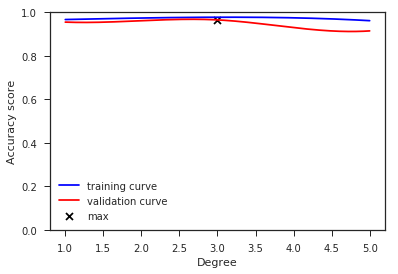

In [16]:
val_curve(model, fpl_xm, fpl_y)

In [17]:
model_fpl = make_pipeline(PolynomialFeatures(best_degree(model, fpl_xm, fpl_y)), LinearRegression())

In [18]:
ict_pred = model_fpl.fit(fpl_xtrain_new, fpl_ytrain).predict(fpl_xtest_new)

In [19]:
r2_score(ict_pred, fpl_ytest)

0.97757750320230175

In [20]:
ict_pred2 = model_fpl.fit(fpl_xtest_new, fpl_ytest).predict(fpl_xtrain_new)

In [21]:
r2_score(ict_pred2, fpl_ytrain)

0.9772933925340952

In [22]:
score_fpl = cross_val_score(model_fpl, fpl_xm, fpl_y, cv = 5)
print(score_fpl)
print(score_fpl.mean())

[ 0.91058212  0.94405378  0.96539119  0.97733126  0.97468598]
0.954408864541


In [23]:
fpl_ult1 = new_output(fpl_xtest, fpl_ytest, ict_pred)

In [24]:
fpl_ult2 = new_output(fpl_xtrain, fpl_ytrain, ict_pred2)

In [25]:
fpl_ult1.head()

,player_name,goals_scored,assists,minutes,position_index,clean_sheets,total_points,ict,ict_pred
25253,Leroy Fer,7,3,3674,3,8,135,177.1,201.187255
44049,Roberto Pereyra,13,10,5103,3,10,238,321.1,358.155635
14594,Lukasz Fabianski,0,0,3240,1,7,116,75.9,82.648242
11163,Marko Grujic,0,0,30,3,0,2,2.9,1.877615
21600,Wes Morgan,1,1,3780,2,9,102,120.6,121.612091


In [26]:
fpl_ult2.head()

,player_name,goals_scored,assists,minutes,position_index,clean_sheets,total_points,ict,ict_pred
31484,Matt Targett,0,0,539,2,1,14,24.6,16.671050
23653,Tom Ince,1,1,1678,4,6,56,95.7,78.808282
16915,James Milner,7,4,3290,3,13,149,243.6,219.838111
8026,Vito Mannone,0,0,450,1,0,14,13.4,15.812388
2087,Jeff Hendrick,1,0,286,3,1,15,13.7,20.654329


In [27]:
fpl_c = pd.concat([fpl_ult1, fpl_ult2], axis = 0)

In [28]:
fpl_c2 = fpl_c.reset_index(drop = True)
fpl_c2.head()

,player_name,goals_scored,assists,minutes,position_index,clean_sheets,total_points,ict,ict_pred
0,Leroy Fer,7,3,3674,3,8,135,177.1,201.187255
1,Roberto Pereyra,13,10,5103,3,10,238,321.1,358.155635
2,Lukasz Fabianski,0,0,3240,1,7,116,75.9,82.648242
3,Marko Grujic,0,0,30,3,0,2,2.9,1.877615
4,Wes Morgan,1,1,3780,2,9,102,120.6,121.612091


In [29]:
fpl_c2.to_csv("~/DSI-SRP1/FPL_ULTIMATE2.csv")